Epoch 200/2000, Loss: 1617.41, NLL: 355.59, KL: 1261.82
Epoch 400/2000, Loss: 1501.80, NLL: 276.67, KL: 1225.13
Epoch 600/2000, Loss: 1414.18, NLL: 226.25, KL: 1187.92
Epoch 800/2000, Loss: 1340.80, NLL: 189.93, KL: 1150.87
Epoch 1000/2000, Loss: 1274.88, NLL: 160.78, KL: 1114.10
Epoch 1200/2000, Loss: 1222.38, NLL: 144.67, KL: 1077.71
Epoch 1400/2000, Loss: 1170.82, NLL: 129.59, KL: 1041.24
Epoch 1600/2000, Loss: 1130.51, NLL: 125.28, KL: 1005.22
Epoch 1800/2000, Loss: 1091.95, NLL: 121.80, KL: 970.15
Epoch 2000/2000, Loss: 1053.37, NLL: 117.39, KL: 935.97


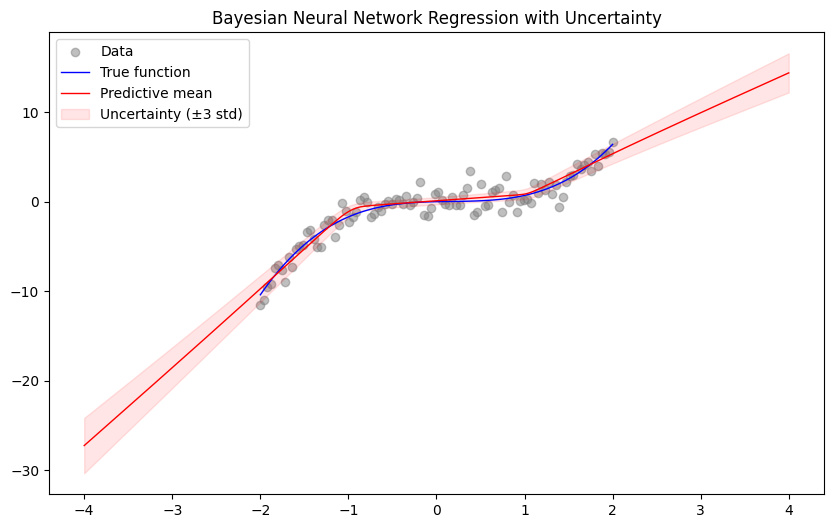

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np
# Generate synthetic data for polynomial regression
torch.manual_seed(0)
N = 1  # Input dimension
num_data = 100
x = torch.linspace(-2, 2, num_data).unsqueeze(1)  # Shape (num_data, N)
# True function: y = x^3 - 0.5 x^2 + 0.2 x + noise
y_true = x**3 - 0.5 * x**2 + 0.2 * x
y = y_true + 1 * torch.randn_like(x)  # Add noise

# Define a Bayesian Linear Layer with spike-and-slab prior
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.0001):
        super(BayesianLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Variational parameters for weights
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5, -4))
        
        # Variational parameters for biases
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5, -4))
        
        # Prior parameters
        self.prior_pi = prior_pi
        self.prior_sigma1 = prior_sigma1
        self.prior_sigma2 = prior_sigma2
        
        self.normal = Normal(0, 1)
        
    def forward(self, input):
        # Sample epsilon for weights and biases
        weight_eps = self.normal.sample(self.weight_mu.size()).to(input.device)
        bias_eps = self.normal.sample(self.bias_mu.size()).to(input.device)
        
        # Compute weight and bias samples via reparameterization
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))  # Softplus to ensure positivity
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        
        weight = self.weight_mu + weight_sigma * weight_eps
        bias = self.bias_mu + bias_sigma * bias_eps
        
        # Linear forward pass
        return F.linear(input, weight, bias)
    def kl_loss(self):
        # Compute KL divergence between variational posterior q(w|theta) and prior p(w)
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))  # Softplus for positivity
        # bias_sigma = torch.log1p(torch.exp(self.bias_rho))

        # Variational posterior distributions
        weight_var_posterior = Normal(self.weight_mu, weight_sigma)
        # bias_var_posterior = Normal(self.bias_mu, bias_sigma)

        # Prior is a mixture of two Gaussians
        weight_prior1 = Normal(0, self.prior_sigma1)  # Mean=0, Std=prior_sigma1
        weight_prior2 = Normal(0, self.prior_sigma2)  # Mean=0, Std=prior_sigma2

        # Compute log probabilities under prior for weights
        weight_log_prior1 = weight_prior1.log_prob(self.weight_mu)
        weight_log_prior2 = weight_prior2.log_prob(self.weight_mu)
        weight_log_prior = torch.logsumexp(
            torch.stack([
                weight_log_prior1 + torch.log(torch.tensor(self.prior_pi)),
                weight_log_prior2 + torch.log(torch.tensor(1 - self.prior_pi))
            ]),
            dim=0
        )

        weight_log_posterior = weight_var_posterior.log_prob(self.weight_mu)
        kl_weight = torch.sum(weight_log_posterior - weight_log_prior)

        # Compute log probabilities under prior for biases
        # bias_log_prior1 = weight_prior1.log_prob(self.bias_mu)
        # bias_log_prior2 = weight_prior2.log_prob(self.bias_mu)
        # bias_log_prior = torch.logsumexp(
            # torch.stack([
                # bias_log_prior1 + torch.log(torch.tensor(self.prior_pi)),
                # bias_log_prior2 + torch.log(torch.tensor(1 - self.prior_pi))
            # ]),
            # dim=0
        # )

        # bias_log_posterior = bias_var_posterior.log_prob(self.bias_mu)
        # kl_bias = torch.sum(bias_log_posterior - bias_log_prior)

        return kl_weight #+ kl_bias

# Define the Bayesian Neural Network
class BayesianNet(nn.Module):
    def __init__(self, prior_pi=0.5, prior_sigma1=1.0, prior_sigma2=0.1):
        super(BayesianNet, self).__init__()
        self.blinear1 = BayesianLinear(1, 100, 0.1, prior_sigma1, 0.00001)
        self.blinear2 = BayesianLinear(100, 1, 0.2, prior_sigma1, 0.00001)
        
    def forward(self, x):
        x = F.relu(self.blinear1(x))
        x = self.blinear2(x)
        return x
    
    def kl_loss(self):
        return self.blinear1.kl_loss() + self.blinear2.kl_loss()

# Instantiate the model and optimizer
model = BayesianNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(x)
    kl = model.kl_loss()
    nll = F.mse_loss(y_pred, y, reduction='sum')  # Sum over data points
    
    loss = kl + nll
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}, NLL: {nll.item():.2f}, KL: {kl.item():.2f}')

# Plot the# Plot the results
model.eval()
with torch.no_grad():
    x_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_preds = []
    for _ in range(100):  # Sample multiple times to get uncertainty estimates
        y_sample = model(x_test).squeeze().numpy()  # Generate predictions
        y_preds.append(y_sample)
    
    y_preds = np.array(y_preds)  # Shape: (100, 200) (samples, data points)
    y_mean = y_preds.mean(axis=0)  # Predictive mean
    y_std = y_preds.std(axis=0)  # Predictive standard deviation

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x.numpy(), y_true.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_mean, label='Predictive mean', linewidth=1, color='red')
plt.fill_between(x_test.squeeze().numpy(), 
                 y_mean - 3 * y_std, 
                 y_mean + 3 * y_std, 
                 color='red', alpha=0.1, label='Uncertainty (±3 std)')
plt.title("Bayesian Neural Network Regression with Uncertainty")
plt.legend()
plt.show()



Pruning at epoch 1, Err: 95.24, Pruning rate: 0.10
Pruning at epoch 2, Err: 95.03, Pruning rate: 0.11
Pruning at epoch 3, Err: 94.87, Pruning rate: 0.12
Pruning at epoch 4, Err: 94.60, Pruning rate: 0.13
Pruning at epoch 5, Err: 94.49, Pruning rate: 0.14
Pruning at epoch 6, Err: 94.42, Pruning rate: 0.15
Pruning at epoch 7, Err: 94.39, Pruning rate: 0.16
Pruning at epoch 8, Err: 94.39, Pruning rate: 0.17
Pruning at epoch 9, Err: 94.39, Pruning rate: 0.18
Pruning at epoch 10, Err: 94.37, Pruning rate: 0.19
Pruning at epoch 11, Err: 94.37, Pruning rate: 0.20
Pruning at epoch 12, Err: 94.32, Pruning rate: 0.21
Pruning at epoch 13, Err: 94.53, Pruning rate: 0.22
Pruning at epoch 14, Err: 98.66, Pruning rate: 0.23
Pruning at epoch 15, Err: 98.58, Pruning rate: 0.24
Pruning at epoch 16, Err: 102.73, Pruning rate: 0.25
Pruning at epoch 17, Err: 114.12, Pruning rate: 0.26
Pruning at epoch 18, Err: 114.12, Pruning rate: 0.27
Epoch 19/100, Loss: 305.04


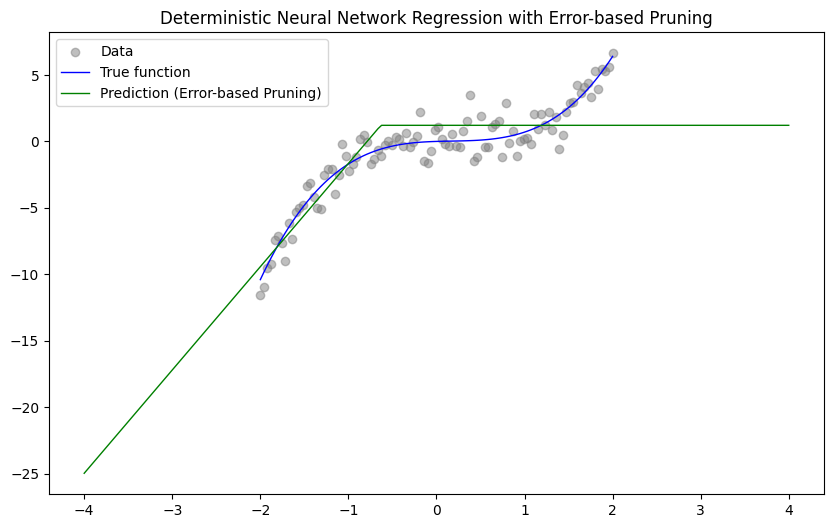

In [40]:
import torch.nn.utils.prune as prune

# Define a deterministic network
class PrunableNet(nn.Module):
    def __init__(self):
        super(PrunableNet, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Pruning function
def apply_pruning(model, pruning_rate):
    """
    Apply pruning to all prunable layers in the model.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):  # Apply pruning only to Linear layers
            prune.l1_unstructured(module, name='weight', amount=pruning_rate)

# Remove pruning reparameterization (optional after final pruning)
def remove_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.remove(module, 'weight')

# Instantiate model, optimizer, and define training loop
prunable_model = PrunableNet()
optimizer = optim.Adam(prunable_model.parameters(), lr=0.01)

# Training loop with error-based pruning
num_epochs = 100
pruning_rate = 0.1  # Initial pruning rate
max_err_threshold = 200  # Loss threshold for pruning
pruning_rate_increment = 0.01  # Increment for pruning rate after each pruning step

current_pruning_rate = pruning_rate


for epoch in range(num_epochs):

    for _ in range(1000):
        prunable_model.train()
        optimizer.zero_grad()
        
        y_pred = prunable_model(x)
        loss = F.mse_loss(y_pred, y, reduction='sum')  # Sum over data points
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 200 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}')


    error = F.mse_loss(prunable_model(x), y, reduction='sum').item()

    
    # Monitor error and apply pruning if loss exceeds threshold
    if error < max_err_threshold:
        try:
            import copy
            best_model = remove_pruning(copy.deepcopy(prunable_model))
            print("Best model found")
        except:
            pass

        print(f'Pruning at epoch {epoch+1}, Err: {error:.2f}, Pruning rate: {current_pruning_rate:.2f}')
        apply_pruning(prunable_model, current_pruning_rate)
        current_pruning_rate += pruning_rate_increment  # Increase pruning rate for next step
        current_pruning_rate = min(current_pruning_rate, 1.0)  # Ensure pruning rate does not exceed 1.0
    else:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}')
        break

# Remove pruning reparameterization after training (optional)
remove_pruning(prunable_model)

# Plot the results after pruning
prunable_model.eval()
with torch.no_grad():
    x_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_test_pred = prunable_model(x_test).squeeze().numpy()  # Generate predictions

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x.numpy(), y_true.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_test_pred, label='Prediction (Error-based Pruning)', linewidth=1, color='green')
plt.title("Deterministic Neural Network Regression with Error-based Pruning")
plt.legend()
plt.show()


In [43]:
# count sparsity of the model
non_zero = 0
total = 0

for name, module in prunable_model.named_modules():
    if isinstance(module, nn.Linear):
        total += module.weight.nelement()
        non_zero += module.weight.nonzero().size(0)

print(f"Sparsity: {100 * (1 - non_zero / total):.2f}%")

Sparsity: 98.00%


In [ ]:

# Plot the results after pruning
prunable_model.eval()
with torch.no_grad():
    x_test = torch.linspace(-4, 4, 200).unsqueeze(1)
    y_test_pred = prunable_model(x_test).squeeze().numpy()  # Generate predictions

plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Data', alpha=0.5)
plt.plot(x.numpy(), y_true.numpy(), label='True function', linewidth=1, color='blue')
plt.plot(x_test.numpy(), y_test_pred, label='Prediction (Error-based Pruning)', linewidth=1, color='green')
plt.title("Deterministic Neural Network Regression with Error-based Pruning")
plt.legend()
plt.show()


In [ ]:
prunable_m